In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

## read flyai data for vision task

In [3]:
path_root = Path('../vision/PlantSeedlingsClassification_FlyAI/')
path_train = path_root/'data/local/train'
path_test = path_root/'data/local/test'
path_train.ls(),path_test.ls()

([PosixPath('../vision/PlantSeedlingsClassification_FlyAI/data/local/train/train.csv'),
  PosixPath('../vision/PlantSeedlingsClassification_FlyAI/data/local/train/img'),
  PosixPath('../vision/PlantSeedlingsClassification_FlyAI/data/local/train/models')],
 [PosixPath('../vision/PlantSeedlingsClassification_FlyAI/data/local/test/test.csv'),
  PosixPath('../vision/PlantSeedlingsClassification_FlyAI/data/local/test/img')])

In [4]:
trn_csv = pd.read_csv(path_train/'train.csv')
val_csv = pd.read_csv(path_test/'test.csv')
trn_csv.head(),val_csv.head()

(                path                   seedling
 0  img/163c13912.png                Black-grass
 1  img/1e0caafd3.png                   Cleavers
 2  img/19ae90c5c.png  Small-flowered Cranesbill
 3  img/455546801.png                Black-grass
 4  img/c0fd4e4aa.png           Common Chickweed,
                 path           seedling
 0  img/af98e2c11.png   Common Chickweed
 1  img/d89fa34ab.png   Loose Silky-bent
 2  img/5f5015641.png            Fat Hen
 3  img/8c742310c.png  Scentless Mayweed
 4  img/b2b62db50.png   Loose Silky-bent)

In [5]:
data=ImageDataBunch.from_df(path=path_train,df=trn_csv,ds_tfms=get_transforms(),size=224,bs=64,valid_pct=0).normalize(imagenet_stats)
data_val=ImageDataBunch.from_df(path=path_test,df=val_csv,ds_tfms=get_transforms(),size=224,bs=64,valid_pct=0).normalize(imagenet_stats)
data.valid_dl= data_val.train_dl
data

ImageDataBunch;

Train: LabelList (2850 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Black-grass,Cleavers,Small-flowered Cranesbill,Black-grass,Common Chickweed
Path: ../vision/PlantSeedlingsClassification_FlyAI/data/local/train;

Valid: LabelList (950 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Common Chickweed,Loose Silky-bent,Fat Hen,Scentless Mayweed,Loose Silky-bent
Path: ../vision/PlantSeedlingsClassification_FlyAI/data/local/test;

Test: None

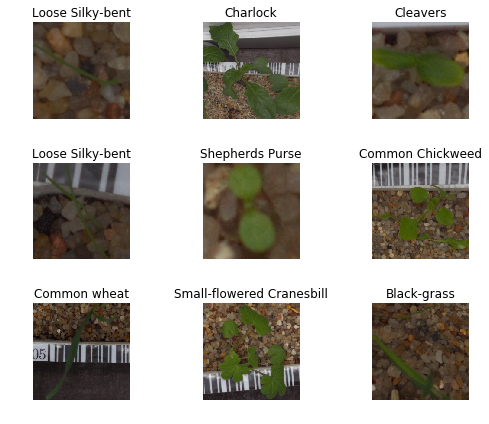

In [6]:
data.show_batch(rows=3,figsize=(7,6))

In [7]:
print(data.classes)

['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


In [7]:
@dataclass
class Fbeta_binary(Callback):
    "Computes the fbeta between preds and targets for single-label classification"
    beta2: int = 2
    eps: float = 1e-9
    clas:int=1
    
    def on_epoch_begin(self, **kwargs):
        self.TP = 0
        self.total_y_pred = 0   
        self.total_y_true = 0
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        y_pred = last_output.argmax(dim=1)
        y_true = last_target.float()
        
        self.TP += ((y_pred==self.clas) * (y_true==self.clas)).float().sum()
        self.total_y_pred += (y_pred==self.clas).float().sum()
        self.total_y_true += (y_true==self.clas).float().sum()
    
    def on_epoch_end(self, **kwargs):
        beta2=self.beta2**2
        prec = self.TP/(self.total_y_pred+self.eps)
        rec = self.TP/(self.total_y_true+self.eps)       
        res = (prec*rec)/(prec*beta2+rec+self.eps)*(1+beta2)
        self.metric = res

In [8]:
from learner import model_meta

In [9]:
model_meta

{<function torchvision.models.resnet.resnet18(pretrained=False, **kwargs)>: {'cut': -2,
  'split': <function learner._resnet_split(m:torch.nn.modules.module.Module)>},
 <function torchvision.models.resnet.resnet34(pretrained=False, **kwargs)>: {'cut': -2,
  'split': <function learner._resnet_split(m:torch.nn.modules.module.Module)>},
 <function torchvision.models.resnet.resnet50(pretrained=False, **kwargs)>: {'cut': -2,
  'split': <function learner._resnet_split(m:torch.nn.modules.module.Module)>},
 <function torchvision.models.resnet.resnet101(pretrained=False, **kwargs)>: {'cut': -2,
  'split': <function learner._resnet_split(m:torch.nn.modules.module.Module)>},
 <function torchvision.models.resnet.resnet152(pretrained=False, **kwargs)>: {'cut': -2,
  'split': <function learner._resnet_split(m:torch.nn.modules.module.Module)>},
 <function torchvision.models.squeezenet.squeezenet1_0(pretrained=False, **kwargs)>: {'cut': -1,
  'split': <function learner._squeezenet_split(m:torch.nn.mod

In [28]:
for m in list(model_meta.keys()):
    print(m)#learn = None
    try:
        gc.collect()
        torch.cuda.empty_cache()
        learn = create_cnn(data,m,metrics = [error_rate,accuracy, Fbeta_binary(beta2=1,clas = 1)])
        learn.fit_one_cycle(4)
    except:
        print('too many parameters')

<function resnet18 at 0x7f3e40812d90>


epoch,train_loss,valid_loss,error_rate,accuracy,fbeta_binary
1,2.111534,1.091852,0.328125,0.671875,0.741722
2,1.334934,0.659605,0.218750,0.781250,0.875817
3,0.958950,0.529493,0.177455,0.822545,0.896552
4,0.748559,0.538786,0.187500,0.812500,0.906667


<function resnet34 at 0x7f3e407a6268>


epoch,train_loss,valid_loss,error_rate,accuracy,fbeta_binary
1,2.055648,0.962370,0.340402,0.659598,0.764331
2,1.261020,0.541490,0.189732,0.810268,0.901408
3,0.873321,0.454185,0.150670,0.849330,0.900000
4,0.667299,0.430029,0.148438,0.851562,0.909091


<function resnet50 at 0x7f3e407a62f0>


epoch,train_loss,valid_loss,error_rate,accuracy,fbeta_binary
1,1.590524,0.716286,0.228795,0.771205,0.887417
2,0.933563,0.417420,0.141741,0.858259,0.950355
3,0.607704,0.339944,0.128348,0.871652,0.958904
4,0.442827,0.319264,0.107143,0.892857,0.972603


<function resnet101 at 0x7f3e407a6378>


epoch,train_loss,valid_loss,error_rate,accuracy,fbeta_binary
1,1.551033,0.605073,0.213170,0.786830,0.840764
2,0.832940,0.340448,0.116071,0.883929,0.960000
3,0.525631,0.287370,0.104911,0.895089,0.970588
4,0.370506,0.296418,0.099330,0.900670,0.965986


<function resnet152 at 0x7f3e407a6400>


epoch,train_loss,valid_loss,error_rate,accuracy,fbeta_binary


too many parameters
<function squeezenet1_0 at 0x7f3e407a6ae8>


/home/changebio/anaconda3/envs/fastv1/lib/python3.6/site-packages/torchvision/models/squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data)
/home/changebio/anaconda3/envs/fastv1/lib/python3.6/site-packages/torchvision/models/squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, mean=0.0, std=0.01)


epoch,train_loss,valid_loss,error_rate,accuracy,fbeta_binary
1,1.953833,1.041459,0.345982,0.654018,0.751773
2,1.284484,0.652514,0.214286,0.785714,0.930556
3,0.936623,0.587080,0.203125,0.796875,0.885714
4,0.750402,0.549802,0.189732,0.810268,0.897959


<function squeezenet1_1 at 0x7f3e407a6d90>


epoch,train_loss,valid_loss,error_rate,accuracy,fbeta_binary
1,1.939681,1.044655,0.366071,0.633929,0.717241
2,1.261862,0.704533,0.247768,0.752232,0.869565
3,0.962833,0.602316,0.196429,0.803571,0.925170
4,0.781083,0.569743,0.194196,0.805804,0.898551


<function densenet121 at 0x7f3e407b2bf8>


/home/changebio/anaconda3/envs/fastv1/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


epoch,train_loss,valid_loss,error_rate,accuracy,fbeta_binary
1,1.736597,0.825552,0.245536,0.754464,0.871429
2,0.948670,0.405167,0.123884,0.876116,0.979021
3,0.580865,0.307066,0.102679,0.897321,0.992908
4,0.407002,0.277220,0.094866,0.905134,0.986301


<function densenet169 at 0x7f3e407b2c80>


epoch,train_loss,valid_loss,error_rate,accuracy,fbeta_binary


too many parameters
<function densenet201 at 0x7f3e407b2d08>


epoch,train_loss,valid_loss,error_rate,accuracy,fbeta_binary


too many parameters
<function densenet161 at 0x7f3e407b2d90>


epoch,train_loss,valid_loss,error_rate,accuracy,fbeta_binary


too many parameters
<function vgg16_bn at 0x7f3e407a6950>


epoch,train_loss,valid_loss,error_rate,accuracy,fbeta_binary
1,2.085959,1.154827,0.347098,0.652902,0.818182
2,1.274722,0.550416,0.184152,0.815848,0.917197
3,0.856693,0.464343,0.149554,0.850446,0.940397
4,0.655270,0.430932,0.141741,0.858259,0.934211


<function vgg19_bn at 0x7f3e407a6a60>


epoch,train_loss,valid_loss,error_rate,accuracy,fbeta_binary
1,2.037716,1.091339,0.341518,0.658482,0.768212
2,1.245656,0.556614,0.196429,0.803571,0.923077
3,0.846557,0.453369,0.156250,0.843750,0.949640
4,0.645012,0.448933,0.168527,0.831473,0.943662


<function alexnet at 0x7f3e408128c8>


epoch,train_loss,valid_loss,error_rate,accuracy,fbeta_binary
1,2.273200,1.401725,0.454241,0.545759,0.675159
2,1.583239,0.937740,0.315848,0.684152,0.791045
3,1.237444,0.813291,0.260045,0.739955,0.805369
4,1.050631,0.808604,0.267857,0.732143,0.820513


In [61]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


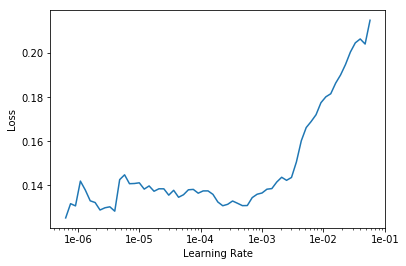

In [62]:
learn.recorder.plot()

In [63]:
learn.unfreeze()
learn.fit_one_cycle(2,max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.118870,0.104693,0.037427
2,0.108816,0.105676,0.039426


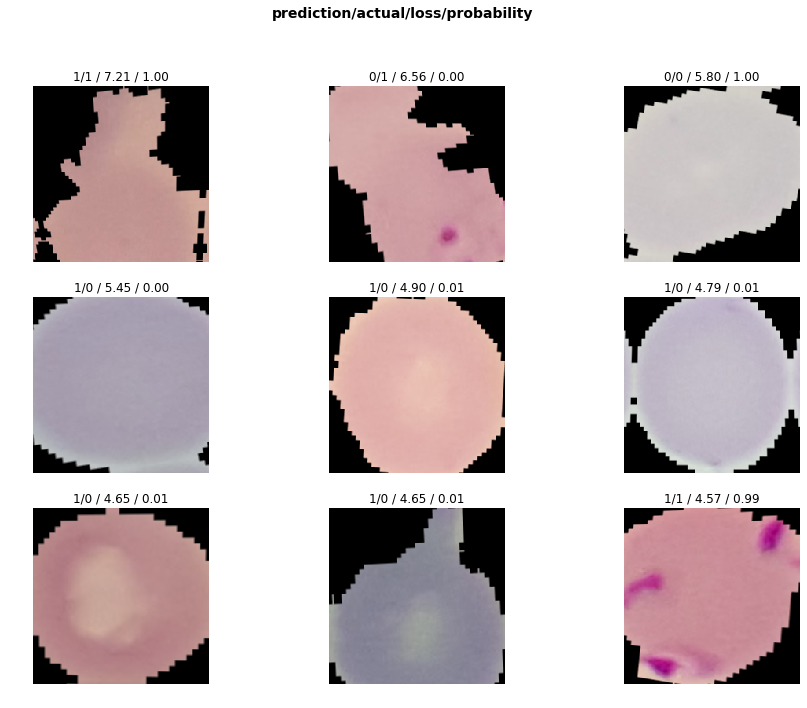

In [57]:
interp.plot_top_losses(9,figsize=(15,11))

In [ ]:
from torch.utils.data.dataset import Dataset
from torchvision import transforms

class MyCustomDataset(Dataset):
    def __init__(self, ..., transforms=None):
        # stuff
        ...
        self.transforms = transforms
        
    def __getitem__(self, index):
        # stuff
        ...
        data = # Some data read from a file or image
        if self.transforms is not None:
            data = self.transforms(data)
        # If the transform variable is not empty
        # then it applies the operations in the transforms with the order that it is created.
        return (img, label)

    def __len__(self):
        return count # of how many data(images?) you have
    
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
])
dataset = ImdbWikiDataset(transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=1)

In [43]:
data.valid_ds

LabelList
y: CategoryList (5512 items)
[Category 0, Category 1, Category 1, Category 0, Category 1]...
Path: ../vision/MalariaCellImages_FlyAI/data/local/test
x: ImageItemList (5512 items)
[Image (3, 103, 145), Image (3, 151, 136), Image (3, 127, 118), Image (3, 148, 127), Image (3, 118, 103)]...
Path: ../vision/MalariaCellImages_FlyAI/data/local/test

In [28]:
?DataLoader

In [24]:
data.valid_ds

LabelList
y: CategoryList (3306 items)
[Category 0, Category 0, Category 0, Category 1, Category 0]...
Path: ../vision/MalariaCellImages_FlyAI/data/local/train
x: ImageItemList (3306 items)
[Image (3, 154, 124), Image (3, 124, 109), Image (3, 127, 112), Image (3, 148, 148), Image (3, 109, 106)]...
Path: ../vision/MalariaCellImages_FlyAI/data/local/train

In [20]:
?ImageDataBunch.from_df